<a href="https://colab.research.google.com/github/Eggathin/potential-enigma/blob/main/STA365_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

In [7]:
url = 'https://github.com/Eggathin/potential-enigma/blob/main/test.csv?raw=true'
df = pd.read_csv(url)
df.describe()

,x,y
count,300.000000,300.000000
mean,50.936667,51.205051
std,28.504286,29.071481
min,0.000000,-3.467884
25%,27.000000,25.676502
50%,53.000000,52.170557
75%,73.000000,74.303007
max,100.000000,105.591837


In [13]:
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))

size = 300
X = np.random.randn(size)

# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
  # Empirical Bayes prior
  beta = pm.Normal('b', mu=50, sigma=28)
  mu = beta * X
  sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0)
  y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'])
with MLR:
  idata = pm.sample()

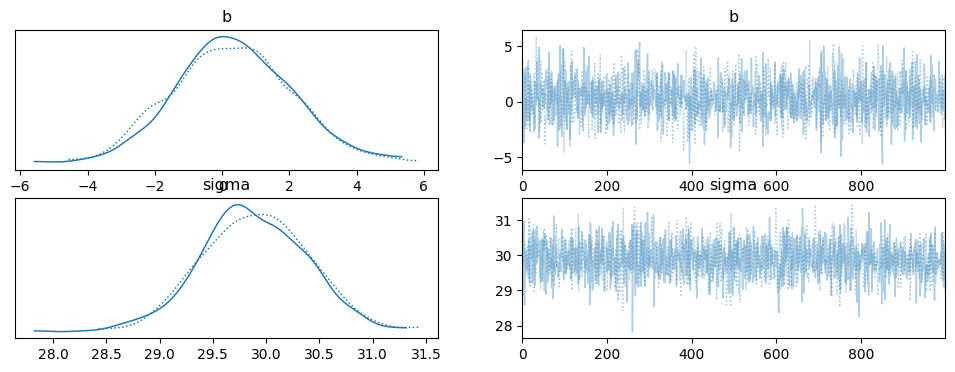

In [19]:
az.plot_trace(idata)
plt.show()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

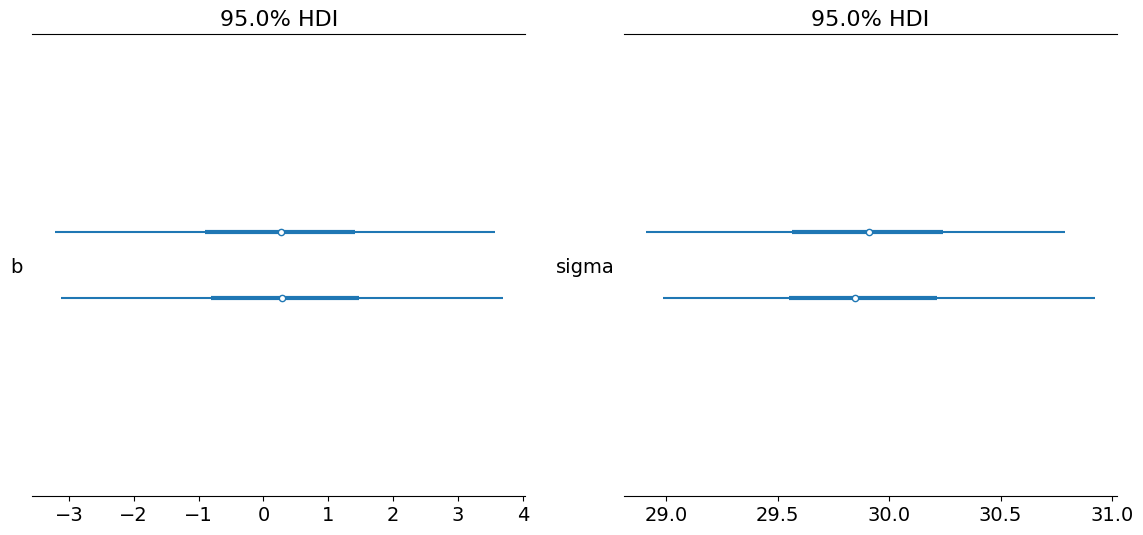

In [29]:
fig,ax = plt.subplots(1,2,figsize=(14,6))
az.plot_forest(idata, var_names=["b"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata, var_names=["sigma"], combined=False, hdi_prob=0.95, ax=ax[1])

In [27]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.32,1.76,-2.78,3.73,0.04,0.04,2035.80,1398.54,1.0
sigma,29.89,0.49,28.97,30.81,0.01,0.01,1888.44,1195.35,1.0


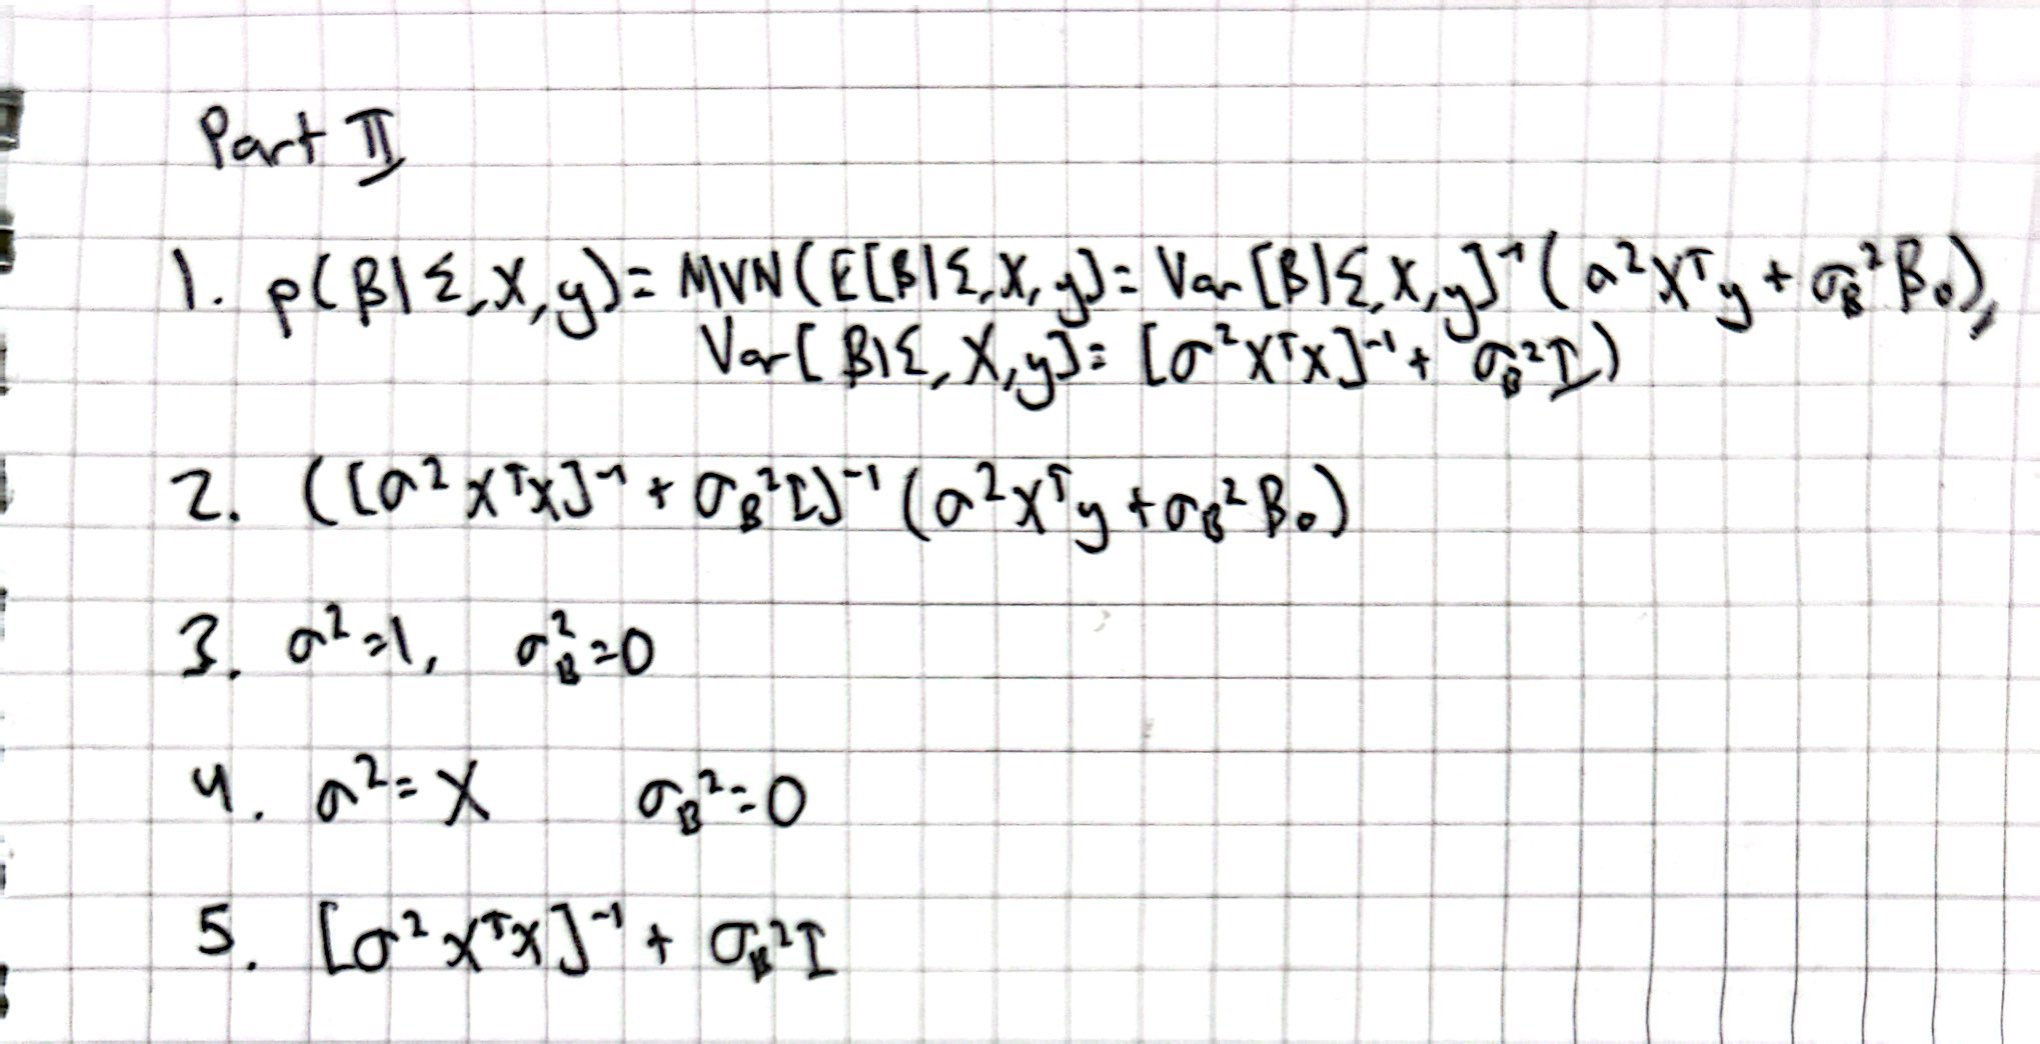

In [37]:
p=10; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
n=1000; y=stats.multivariate_normal(mean=np.zeros(p), cov=a_cov).rvs(size=n)
# Replace this made up data with your data set from kaggle...

with pm.Model() as MNV_LKJ:
  packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                               sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
  L = pm.expand_packed_triangular(p, packed_L)
  Sigma = pm.Deterministic('Sigma', L)
  mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p);
  y = pm.MvNormal('y', mu=mu, chol=Sigma, observed=y)
with MNV_LKJ:
  idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


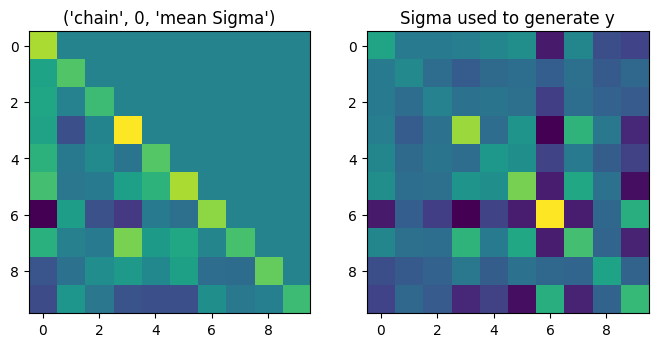

In [60]:
import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2,figsize=(8,4)); ax[-1].imshow(a_cov); ax[1].set_title(("Sigma used to generate y"))
for chain in range(1):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain+1]); ax[chain].set_title(("chain",chain,"mean Sigma"))